<a href="https://colab.research.google.com/github/arko-saha/Brain-tumor-detection-from-MRI-images-using-Convolutional-Neural-Network-based-technique/blob/main/Coursework_2_3_Arko_Saha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Arko Saha </br>
Student ID: SAH21527466 </br>
Topic: Coursework 2 & 3 </br>
Module No.: CMP020L015A </br>
Module name: Machine Learning </br>
Module Tutor: Dr. Yuanlin Gu </br> 

Dataset: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/code

In [ ]:
# import the modules

import os
import math
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import cv2

# plt.style.use('ggplot')

import tensorflow as tf
from sklearn.metrics import *
from tensorflow import keras

Now, let's load the data to the Google Colab.  

In [ ]:
# Load the data

from urllib.request import urlopen
import zipfile
from io import BytesIO
from google.colab import drive

import warnings
warnings.filterwarnings('ignore')

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("brain_tumor_dataset.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
SEED = 40
main_dir = "/tmp/brain_tumor_dataset"
os.listdir(main_dir)

['no', 'yes']

In [ ]:
subdirs = os.listdir(main_dir)[:2]
for subdir in subdirs:
    print(f"{subdir} contains {len(os.listdir(main_dir+'/'+subdir))} images")

no contains 98 images
yes contains 155 images


In [ ]:
def load_images(folder):
    
    imgs = []
    target = 0
    labels = []
    for i in os.listdir(folder):
        subdir = os.path.join(folder, i)
        for j in os.listdir(subdir):
            img_dir = os.path.join(subdir,j)
            try:
                img = cv2.imread(img_dir)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (128,128))
                imgs.append(img)
                labels.append(target)
            except:
                continue
        target += 1
    
    imgs = np.array(imgs)
    labels = np.array(labels)
    
    return imgs, labels

In [ ]:
data, labels = load_images(main_dir)
data.shape, labels.shape

((253, 128, 128), (253,))

# Split the data
Now that we have loaded the dataset, let's split the data into training and testing sets. 

In [ ]:
# Defining training and testing set

!apt-get install tree
#clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
mkdir: cannot create directory ‘TRAIN’: File exists
mkdir: cannot create directory ‘TEST’: File exists
mkdir: cannot create directory ‘VAL’: File exists
mkdir: cannot create directory ‘TRAIN/YES’: File exists
mkdir: cannot create directory ‘TRAIN/NO’: File exists
mkdir: cannot create directory ‘TEST/YES’: File exists
mkdir: cannot create directory ‘TEST/NO’: File exists
mkdir: cannot create directory ‘VAL/YES’: File exists
mkdir: cannot create directory ‘VAL/NO’: File exists
.
├── drive
│   └── MyDrive
│       ├── Classroom
│       │   ├── I O Device in PLC Powerpoints
│       │   ├── ML Mastery Machine Learning
│       │   ├── One A
│       │   └── Sp

In [ ]:
import shutil

IMG_PATH = main_dir
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
  IMG_NUM = len(os.listdir(IMG_PATH + '/' + CLASS))
  for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + '/' + CLASS)):
    img = IMG_PATH + '/' + CLASS + '/' + FILE_NAME
    if n < 5:
      shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
    elif n < 0.8*IMG_NUM:
      shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
    else:
      shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [ ]:
from tqdm import tqdm
import itertools

def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  3.48it/s]


193 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 63.33it/s]


10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 13.50it/s]

50 images loaded from VAL/ directory.


Now, let's plot the images for both positive and negative findings. We will now plot images with no brain tumor findings within the range (0,97).   

In [ ]:
def plot_images(start, end):
    plt.figure(figsize=(22,8))
    for i in range(10):
        axs = plt.subplot(2,5, i+1)
        idx = np.random.randint(start, end)
        plt.imshow(data[idx], cmap='gray')
        plt.axis('on')
        axs.set_xticklabels([])
        axs.set_yticklabels([])
        plt.subplots_adjust(wspace=None, hspace=None)

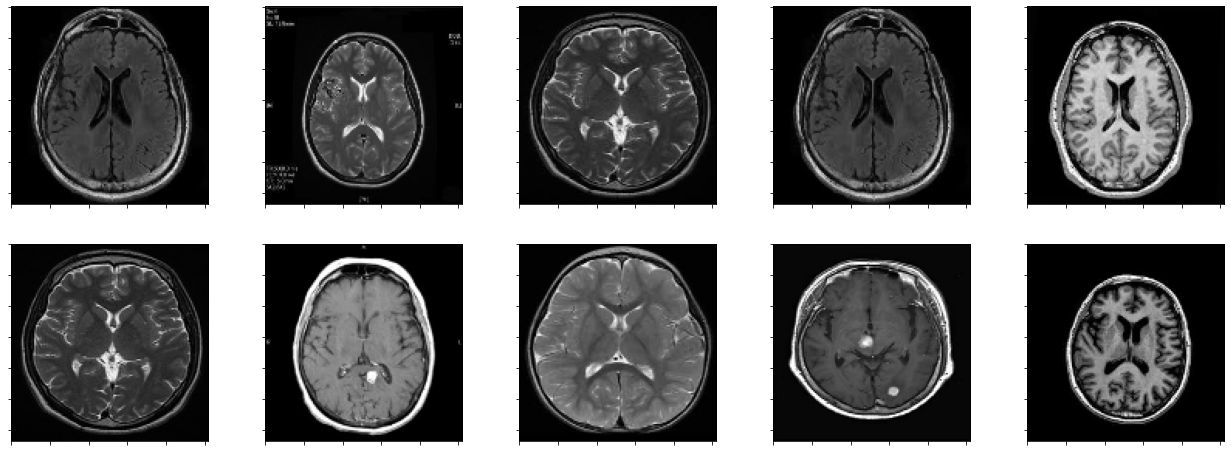

In [ ]:
plot_images(0, 97)

Now, we will look into the images with tumor findings from the MRI. For this, we will choose the range (98,252). 

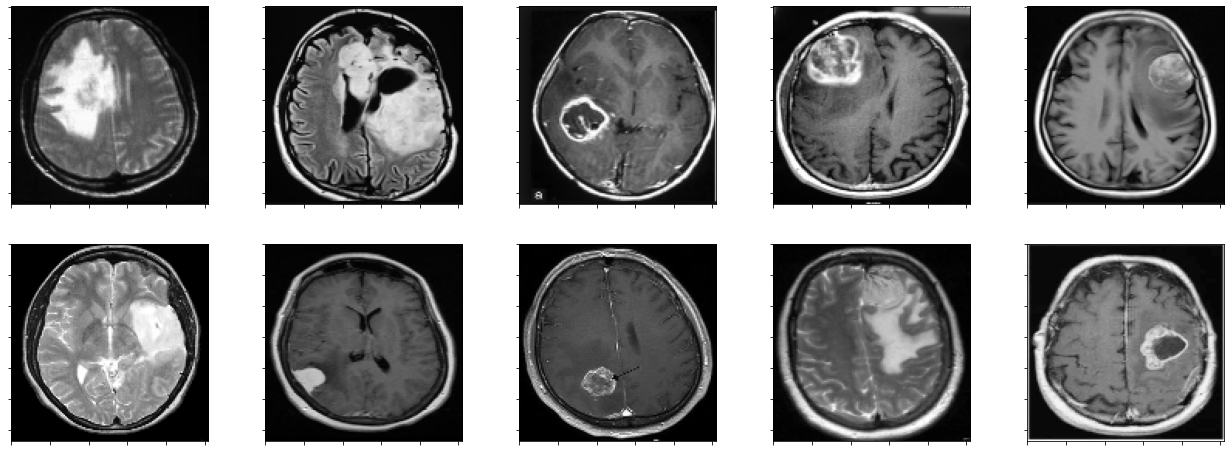

In [ ]:
plot_images(98, 252)

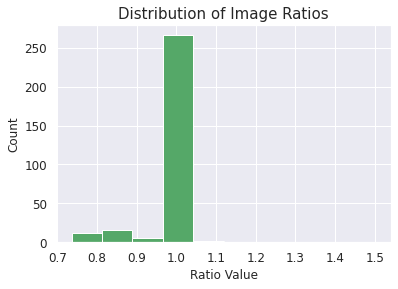

In [ ]:
import matplotlib

RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST, facecolor='g')
label_font = {'size':'12'}  # Adjust to fit
title_font = {'size':'15'}  # Adjust to fit
plt.tick_params(axis='both', which='major', labelsize=12)  # Adjust to fit
plt.title('Distribution of Image Ratios', title_font)
plt.xlabel('Ratio Value', fontdict=label_font)
plt.ylabel('Count', fontdict=label_font)
plt.show()

# Normalise the Images

Normalisation is an essential step in image classification. However, this step was not mandatory since the images in this dataset are already in grayscale.

Firstly, let's crop out the unnecessary parts from the images as a part of instance segmentation. 

In [ ]:
X = []
y = []
Classes = {'no':0, 'yes':1}
for i in Classes:
    path = main_dir+'/'+i
    for j in os.listdir(path):
        img = cv2.imread(path+'/'+j, 0)
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # resize image
        img = cv2.resize(img, (240,240),interpolation=cv2.INTER_CUBIC)
        # normalize values
        img = img / 255  #-->Apply normalization because we want pixel values to be scaled to the range 0-1
        X.append(img)
        y.append(Classes[i])

In [ ]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((253, 240, 240), (253,))

In [ ]:
import plotly.express as px

Class_series=pd.Series(y)
lis=["No Tumor","Tumor"]
Tumor_or_not = Class_series.value_counts().tolist()
values = [Tumor_or_not[0], Tumor_or_not[1]]
fig = px.pie(values=Class_series.value_counts(), names=lis , width=800, height=400, color_discrete_sequence=["lightgreen","salmon"]
             ,title="percentage between Tumor & No Tumor")
fig.show()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=32)

In [ ]:
X_train.shape

(202, 240, 240)

In [ ]:
X_train = X_train.reshape(-1, 240, 240, 1)
X_test = X_test.reshape(-1, 240, 240, 1)
X_train.shape

(202, 240, 240, 1)

# Creating a neural network

In [ ]:
tf.random.set_seed(SEED)

# Building the CNN

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64,
                           kernel_size=3,
                           activation='relu',
                           input_shape=(240,240,1)),
    tf.keras.layers.Conv2D(32,(4,4),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),
                              padding='valid'),
    tf.keras.layers.Conv2D(32,(4,4),activation='relu'),
    tf.keras.layers.Conv2D(16,3,activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model

history = model.fit(x=X_train, y=y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
7/7 [==============================] - 142s 20s/step - loss: 0.6564 - accuracy: 0.6040 - val_loss: 0.6129 - val_accuracy: 0.7059
Epoch 2/10
7/7 [==============================] - 147s 21s/step - loss: 0.5326 - accuracy: 0.7574 - val_loss: 0.6826 - val_accuracy: 0.6863
Epoch 3/10
7/7 [==============================] - 142s 20s/step - loss: 0.4795 - accuracy: 0.8020 - val_loss: 0.6797 - val_accuracy: 0.6078
Epoch 4/10
7/7 [==============================] - 139s 20s/step - loss: 0.4415 - accuracy: 0.7871 - val_loss: 0.5827 - val_accuracy: 0.7255
Epoch 5/10
7/7 [==============================] - 143s 20s/step - loss: 0.3941 - accuracy: 0.8317 - val_loss: 0.5800 - val_accuracy: 0.7647
Epoch 6/10
7/7 [==============================] - 144s 21s/step - loss: 0.3224 - accuracy: 0.8663 - val_loss: 0.5316 - val_accuracy: 0.7843
Epoch 7/10
7/7 [==============================] - 146s 21s/step - loss: 0.2899 - accuracy: 0.8960 - val_loss: 0.5120 - val_accuracy: 0.7255
Epoch 8/10
7/7 [====

#Presenting the evaluation results

In [ ]:
result = model.evaluate(x=X_train, y=y_train, verbose=0)
print(f"Accuracy on Evaluation: {result[1]*100:.2f}%\nLoss: {result[0]:.4f}")

Accuracy on Evaluation: 99.50%
Loss: 0.0356


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


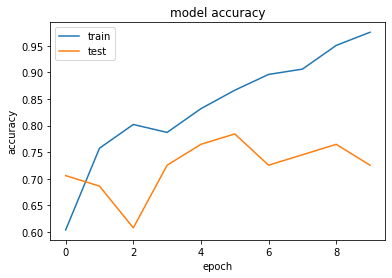

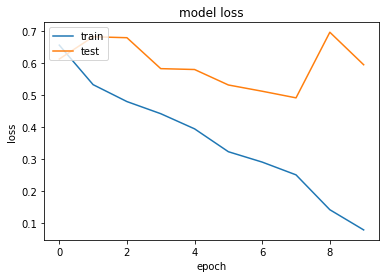

In [ ]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model_loss=pd.DataFrame(history.history)

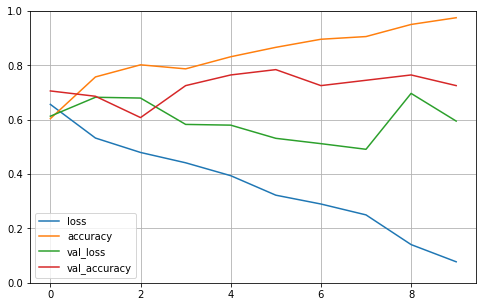

In [ ]:
model_loss.plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

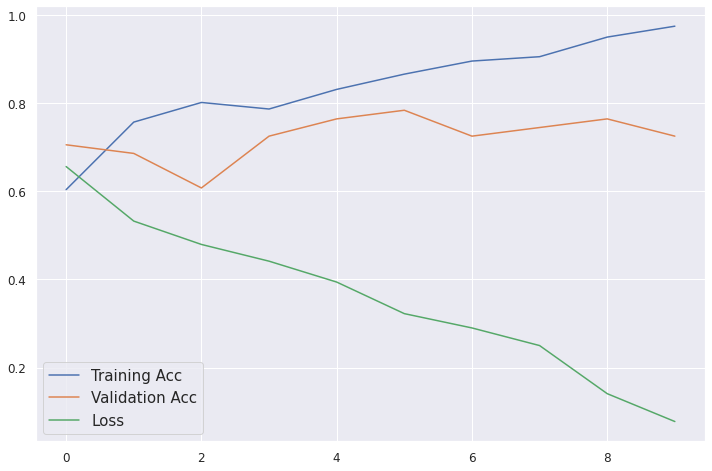

In [ ]:
histdf = pd.DataFrame(history.history)

plt.figure(figsize=(12,8))
plt.plot(histdf['accuracy'], label='Training Acc')
plt.plot(histdf['val_accuracy'], label='Validation Acc')
plt.plot(histdf['loss'], label='Loss')
plt.tick_params(axis='both', which='major', labelsize=12)  # Adjust to fit
plt.legend(loc=3, prop={'size': 15})
plt.show()

In [ ]:
y_predicted_tf =model.predict(X_test).reshape(-1)
y_predicted_tf = [1 if y>=0.5 else 0 for y in y_predicted_tf] 
df = pd.DataFrame({"Y_test": y_test , "Y_predicted" : y_predicted_tf})
df.head(8)

2/2 [==============================] - 5s 2s/step


,Y_test,Y_predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1
5,1,1
6,1,1
7,1,1


In [ ]:
print(classification_report(y_predicted_tf,y_test))

              precision    recall  f1-score   support

           0       0.63      0.63      0.63        19
           1       0.78      0.78      0.78        32

    accuracy                           0.73        51
   macro avg       0.71      0.71      0.71        51
weighted avg       0.73      0.73      0.73        51



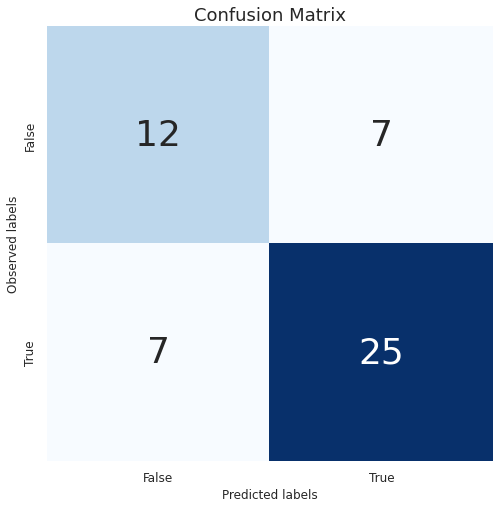

In [ ]:
import seaborn as sns

plt.figure(figsize=(8,8))
cm = confusion_matrix(y_predicted_tf,y_test)
ax = plt.subplot()

sns.set(font_scale=3.0) # Adjust to fit
sns.heatmap(cm, cmap="Blues", annot=True, fmt=".2g", cbar=False)

# Labels, title and ticks
label_font = {'size':'12'}  # Adjust to fit
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);

title_font = {'size':'18'}  # Adjust to fit
ax.set_title('Confusion Matrix', fontdict=title_font);

ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust to fit
ax.xaxis.set_ticklabels(['False', 'True']);
ax.yaxis.set_ticklabels(['False', 'True']);
plt.show()

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 238, 238, 64)      640       
                                                                 
 conv2d_5 (Conv2D)           (None, 235, 235, 32)      32800     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 117, 117, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 114, 114, 32)      16416     
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 16)      4624      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 16)       0         
 2D)                                                  

References:
1. https://www.kaggle.com/code/momenulhaque/brain-tumor-mri-classification-vgg16#3.-Data-Import-and-Preprocessing
2. https://www.kaggle.com/code/harshsingh2209/brain-tumor-detection-cnn
3. https://www.kaggle.com/code/ahmedadell30/cnn-model-tumor-detection